Parameter inference
============

Let's start to import the necessary classes. We also set up matplotlib and we're going to use pandas as well.

In [2]:
import pyabc
import time
import numpy as np
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
###my code
#import numpy as np
#import matplotlib.pyplot as plt
#import pandas as pd
import seaborn as sns
import xarray as xr
import xsimlab as xs

### Define the xsimlab model

In [4]:
@xs.process
class UniformGrid1D:
    """Create 1D model grid with uniform spacing"""
    
    #grid parameters
    spacing = xs.variable(description="grid_spacing", static=True)
    length = xs.variable(description="grid total length", static=True)
    
    #x is an index variable, used for accessing the grid.
    x = xs.index(dims="x")
            
    #create the grid
    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [5]:
@xs.process
class ProfileZ:
    """Compute the evolution of the elevation (z) profile"""
    
    h_vars = xs.group("h_vars") #allows for multiple processes influencing; say diffusion and subsidence
    #br_vars = xs.group("br_vars") #allows for multiple processes influencing; say diffusion and subsidence

    z = xs.variable(
        dims="x", intent="inout", description="surface elevation z", attrs={"units": "m"}
    )
    #br = xs.variable(
    #    dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    #)
    br = xs.variable(
        dims=[(), "x"], intent="in", description="bedrock_elevation", attrs={"units": "m"}
    )
    h = xs.variable(
        dims="x", intent="inout", description="sed_thickness", attrs={"units": "m"}
    )

    def run_step(self):
        #self._delta_br = sum((br for br in self.br_vars))
        self._delta_h = sum((h for h in self.h_vars))

    def finalize_step(self):
        #self.br += self._delta_br #update bedrock surface
        self.h += self._delta_h #update sediment thickness
        self.z = self.br + self.h #add sediment to bedrock to get topo elev.

In [6]:
import numba as nb

@nb.jit(nopython = True, cache = True)
def evolve_remaining_nodes(first_marine_node, z, slope, erosion, k_arr, s_crit, travel_dist, sea_level, deposition, qs, spacing, dh_dt, dh ,sed_porosity, dt,h):
    
    for i in range(first_marine_node + 1, len(z)): #iterate over each element of x ONLY IN THE MARINE
        
        if slope[i] <= 0: #this is the "regular," right-draining case
            deposition[i] = (qs[i-1] * (1 - np.minimum(1, np.power(slope[i] / s_crit, 2)))) / travel_dist
            erosion[i] = k_arr[i] * np.abs(slope[i])
            if z[i] > sea_level:
                deposition[i] = 0
        else: #this is the irregular, left-draining case
            deposition[i] = qs[i-1] / spacing#(self.qs[i-1] * (1 + np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.spacing#self.travel_dist #self.qs[i-1] / self.spacing
            erosion[i] = 0
            if z[i] > sea_level:
                deposition[i] = 0
        dh_dt[i] = (-erosion[i] + deposition[i]) / (1 - sed_porosity)

        dh[i] = dh_dt[i] * dt

        qs[i] = np.maximum(qs[i-1] + (erosion[i] - deposition[i]) * spacing, 0.)

        if -dh[i] > h[i]:
            dh[i] = -h[i]
            qs[i] = np.maximum(qs[i-1] + ((-dh[i] / dt) * (1 - sed_porosity)) * spacing, 0.)
            
            
@nb.jit(nopython = True, cache = True)      
def local_NewtonRaphson_scheme_for_compaction(nn,dh_compact,z0, h, sed_porosity, sed_porosity_depth_scale):
    #Newton-Raphson iteration  at every node
        for k in range(nn):
            fx = 1 #throwaway initial value to trigger "while" loop
            dfx = 1 #throwaway initial value to trigger "while" loop
            #check whether we're at the root
            if dh_compact[k] > 0 : #only apply compaction where deposition is happening
                while np.abs(fx / dfx) > 1e-6:
                    #calculate value of function at initial guess
                    fx = z0[k] - h[k] + sed_porosity * sed_porosity_depth_scale * (np.exp(-z0[k] / sed_porosity_depth_scale) - np.exp(-h[k] / sed_porosity_depth_scale)) - dh_compact[k]
        
                    #calculate derivative
                    dfx = 1 - sed_porosity * np.exp(-z0[k] / sed_porosity_depth_scale)
                    z0[k] = z0[k] - fx / dfx

            elif dh_compact[k] == 0: #no e or d
                z0[k] = h[k]
            else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
                z0[k] = h[k] + dh_compact[k] / (1 - sed_porosity)


In [7]:
@xs.process
class ErosionDeposition:
    """Here's where the actual computation happenfirst_marine_nodecal diffusion

    """
    
    #get input parameters
    basin_width = xs.variable(description="basin width")
    sea_level = xs.variable(description="sea level")
    k_factor = xs.variable(description="k factor")
    k_depth_scale = xs.variable(description="k depth scale")
    travel_dist = xs.variable(description="marine_travel_distance")
    s_crit = xs.variable(description="marine_critical_slope")
    sed_porosity = xs.variable(description="marine_sediment_porosity")
    sed_porosity_depth_scale = xs.variable(description="marine_sediment_porosity_depth_scale")
    qs_in = xs.variable(description="sediment_flux_in")
    
    slope = xs.variable(
        dims="x", intent="out", description="topographic_slope", attrs={"units": "-"}
    )
    depth = xs.variable(
        dims="x", intent="out", description="depth", attrs={"units": "m"}
    )
    erosion = xs.variable(
        dims="x", intent="out", description="erosion", attrs={"units": "m/yr"}
    )
    deposition = xs.variable(
        dims="x", intent="out", description="deposition", attrs={"units": "m/yr"}
    )
    dh_dt = xs.variable(
        dims="x", intent="out", description="dh_dt", attrs={"units": "m/yr"}
    )
    qs = xs.variable(
        dims="x", intent="out", description="qs", attrs={"units": "m2/yr"}
    )
    #dbr = xs.variable(dims="x", intent="out", groups="br_vars")
    dh = xs.variable(dims="x", intent="out", groups="h_vars")
    
    spacing = xs.foreign(UniformGrid1D, "spacing")
    #x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z")
    br = xs.foreign(ProfileZ, "br")
    h = xs.foreign(ProfileZ, "h")
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        k_factor_real = np.power(10, self.k_factor)
        self.erosion = np.repeat(0., len(self.z))
        self.deposition = np.repeat(0., len(self.z))
        self.dh_dt = np.repeat(0., len(self.z))
        self.qs = np.repeat(0., len(self.z))
        self.dh = np.repeat(0., len(self.z))
        
        #divide Qs_in by basin width to get qs_in
        qs_in = self.qs_in / self.basin_width
        
        #calculate topographic slope
        self.slope = np.append(np.diff(self.z) / self.spacing, 0)
        #calculate depth below water
        self.depth = np.maximum(self.sea_level - self.z, 0)
        
        #calculate k array
        k_arr = k_factor_real * np.exp(-self.depth / self.k_depth_scale)
        
        #impose hard basin floor
        k_arr[self.z <= (self.br + 0.001)] = 0
        
        #find first marine node
        marine_or_terrestrial = self.z <= self.sea_level #boolean: true is marine
        first_marine_node = np.argmax(marine_or_terrestrial) #finds the first true
        
        #evolve first marine node
        if self.slope[first_marine_node] <= 0: #this is the "regular," right-draining case
            self.erosion[first_marine_node] = k_arr[first_marine_node] * np.abs(self.slope[first_marine_node])
            self.deposition[first_marine_node] = (qs_in * (1 - np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist

        else:  #this is the irregular, left-draining case
            self.erosion[first_marine_node] = 0 #because slope = 0
            self.deposition[first_marine_node] = qs_in / self.spacing #(self.qs_in * (1 + np.minimum(1, np.power(self.slope[first_marine_node] / self.s_crit, 2)))) / self.travel_dist #because slope = 0 #self.qs_in / self.travel_dist
        self.dh_dt[first_marine_node] = (-self.erosion[first_marine_node] + self.deposition[first_marine_node]) / (1 - self.sed_porosity)
        self.dh[first_marine_node] = self.dh_dt[first_marine_node] * dt
        self.qs[first_marine_node] = np.maximum(qs_in + (self.erosion[first_marine_node] - self.deposition[first_marine_node]) * self.spacing, 0.)
        if -self.dh[first_marine_node] > self.h[first_marine_node]:
            self.dh[first_marine_node] = -self.h[first_marine_node]
            self.qs[first_marine_node] = np.maximum(qs_in + ((-self.dh[first_marine_node] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
        
        
        
        #evolve remaining marine nodes
        evolve_remaining_nodes(first_marine_node, self.z, self.slope, self.erosion, k_arr, self.s_crit, 
                               self.travel_dist, self.sea_level, self.deposition, self.qs, self.spacing,
                               self.dh_dt, self.dh ,self.sed_porosity, dt, self.h)

### First loop
#         for i in range(first_marine_node + 1, len(self.z)): #iterate over each element of x ONLY IN THE MARINE
        
#             if self.slope[i] <= 0: #this is the "regular," right-draining case
#                 self.deposition[i] = (self.qs[i-1] * (1 - np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.travel_dist
#                 self.erosion[i] = k_arr[i] * np.abs(self.slope[i])
#                 if self.z[i] > self.sea_level:
#                     self.deposition[i] = 0
#             else: #this is the irregular, left-draining case
#                 self.deposition[i] = self.qs[i-1] / self.spacing#(self.qs[i-1] * (1 + np.minimum(1, np.power(self.slope[i] / self.s_crit, 2)))) / self.spacing#self.travel_dist #self.qs[i-1] / self.spacing
#                 self.erosion[i] = 0
#                 if self.z[i] > self.sea_level:
#                     self.deposition[i] = 0
#             self.dh_dt[i] = (-self.erosion[i] + self.deposition[i]) / (1 - self.sed_porosity)
            
#             self.dh[i] = self.dh_dt[i] * dt
            
#             self.qs[i] = np.maximum(self.qs[i-1] + (self.erosion[i] - self.deposition[i]) * self.spacing, 0.)
            
#             if -self.dh[i] > self.h[i]:
#                 self.dh[i] = -self.h[i]
#                 self.qs[i] = np.maximum(self.qs[i-1] + ((-self.dh[i] / dt) * (1 - self.sed_porosity)) * self.spacing, 0.)
# End of forst loop
    
    
#         calculate change in sed thickness
#         self.dh[:first_marine_node] = 0
#         self.dh[first_marine_node:] = self.dh_dt[first_marine_node:] * dt
#         self.dh[self.erosion > self.h] = -self.h[self.erosion > self.h] #if erosion is greater than h, topo only loses h    
        
        #compact sediment
        #calculate the thickness after compaction, z0; dh is the thickness of new deposited solid sediment
        dh_compact = self.dh * (1 - self.sed_porosity)
    
        
        #compaction routine
        #def compaction(porosity, porosity_depth_scale, nn, dh, zi):
        nn = len(self.z)
        z0 = np.zeros(nn)
        #set initial guess for z0:
        z0[:] = self.h[:]
        
        local_NewtonRaphson_scheme_for_compaction(nn,dh_compact,z0, self.h, self.sed_porosity, self.sed_porosity_depth_scale)
#         #Newton-Raphson iteration  at every node
#         for k in range(nn):
#             fx = 1 #throwaway initial value to trigger "while" loop
#             dfx = 1 #throwaway initial value to trigger "while" loop
#             #check whether we're at the root
#             if dh_compact[k] > 0 : #only apply compaction where deposition is happening
#                 while np.abs(fx / dfx) > 1e-6:
#                     #calculate value of function at initial guess
#                     fx = z0[k] - self.h[k] + self.sed_porosity * self.sed_porosity_depth_scale * (np.exp(-z0[k] / self.sed_porosity_depth_scale) - np.exp(-self.h[k] / self.sed_porosity_depth_scale)) - dh_compact[k]
        
#                     #calculate derivative
#                     dfx = 1 - self.sed_porosity * np.exp(-z0[k] / self.sed_porosity_depth_scale)
#                     z0[k] = z0[k] - fx / dfx

#             elif dh_compact[k] == 0: #no e or d
#                 z0[k] = self.h[k]
#             else: #in the case where erosion happens, the sediment surface shouldn't rebound. 
#                 z0[k] = self.h[k] + dh_compact[k] / (1 - self.sed_porosity)
        
        #here, have a chance to set the final dh by differencing new h (z0) and old h (h)
        self.dh[:] = z0[:] - self.h[:]
        
        #finalize changes to bedrock (subsidence) and sediment thickness (e/d)
        #self.dbr = (self.subsidence * dt)

In [8]:
@xs.process
class InitBasinGeom:
    """
    Give initial basin elevation field as a function of x:
    z = exp(- (x - a) / b) + c
    """
    
    #a = xs.variable(description="shift parameter", static=True)
    #b = xs.variable(description="scale parameter", static=True)
    #c = xs.variable(description="initial basin floor altitude", static=True)
    #d = xs.variable(description="x multiplier", static=True)

    init_br = xs.variable(dims="x", description="shift parameter", static=True)
    
    x = xs.foreign(UniformGrid1D, "x")
    z = xs.foreign(ProfileZ, "z", intent="out")
    #br = xs.foreign(ProfileZ, "br", intent="in")
    h = xs.foreign(ProfileZ, "h", intent="out")
    
    #k_factor = xs.foreign(ErosionDeposition, "k_factor")
    #k_depth_scale = xs.variable(description="k depth scale")
    #travel_dist = xs.variable(description="marine_travel_distance")
    #s_crit = xs.variable(description="marine_critical_slope")

    def initialize(self):
        #self.br = np.exp(- (self.x * self.d - self.a) / self.b) + self.c #build the initial topography
        self.h = np.zeros(len(self.x)) #initial sediment thickness is 0
        self.z = np.zeros(len(self.x)) + self.init_br #self.br#(np.exp(- (self.x * self.d - self.a) / self.b) + self.c) + self.h


In [9]:
marine = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileZ,
        "init": InitBasinGeom,
        "erode": ErosionDeposition,
    }
)

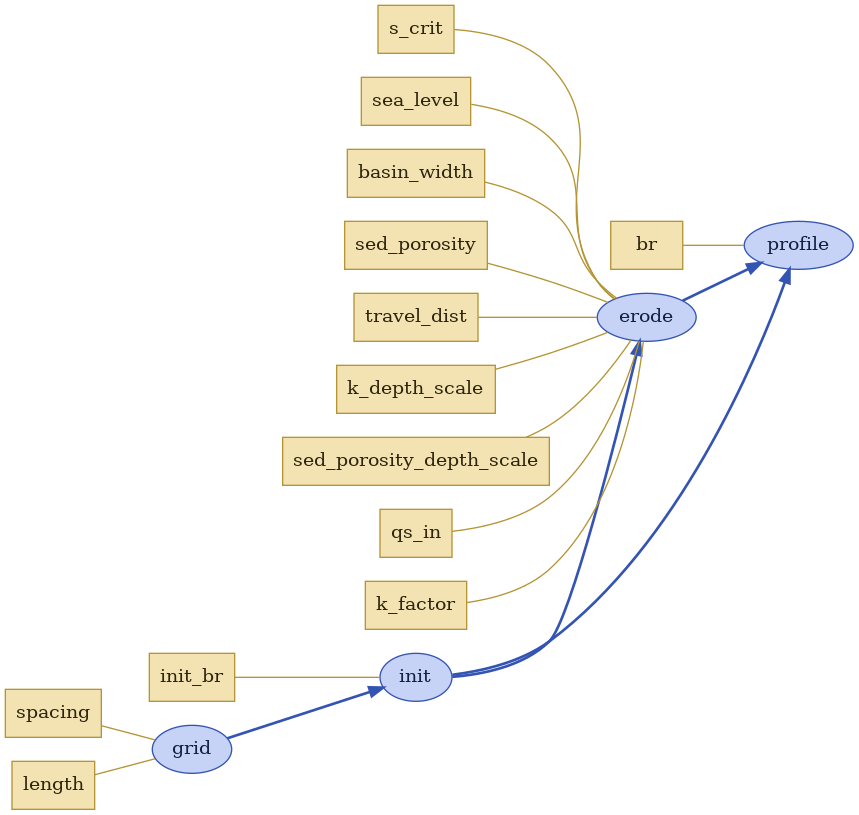

In [10]:
marine.visualize(show_inputs=True)

In [11]:
#need to import basement elevation and qs time series after they were exported by the prepro notebook
bedrock_file = '../prepro/bedrock_elev_array.npy'
br = np.load(bedrock_file)
bedrock_elev_array = xr.DataArray(br, dims=['time', 'x'])
initial_bedrock = bedrock_elev_array[0, :]

qs_file = '../prepro/qs_array.npy'
qs_array = np.load(qs_file)
qs_array = xr.DataArray(qs_array, dims=['time'])
#this is loading in the full m3/yr numbers directly from Baby et al 2019.

#so need to divide by the basin width before piping it into the model.
#import best-fit basin width from pyABC inference
#basin_width_file = '../step1_qs_in/best_fit_basin_width.npy'
#basin_width = np.load(basin_width_file)[0] #first and only element of array
#qs_array = qs_array[:] / basin_width #now we're in the right units for the model

In [12]:
in_ds = xs.create_setup(
   ...:     model=marine,
   ...:     clocks={
   ...:         'time': np.arange(0, 130000000, 1000),
   ...:         'otime': np.array([129999000]) #np.array([19999000])
   ...:     },
   ...:     master_clock='time',
   ...:     input_vars={
   ...:         'grid': {'length': 740000., 'spacing': 10000.},
                'init': {'init_br': initial_bedrock},
                'erode': {
                    'k_factor': 1.,
                    'k_depth_scale': 100.,
                    's_crit': 0.1,
                    'travel_dist': 10000.,
                    'sed_porosity': 0.56,
                    'sed_porosity_depth_scale': 2830.,
                    'sea_level': 0.,
                    'qs_in': qs_array,
                    'basin_width': 1.0
                },
                'profile': {
                    'br': bedrock_elev_array
                },
   },
            output_vars={'profile__z': 'otime', 'profile__br': 'otime', 'profile__h': 'otime'}
)

In [13]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R5/step2_params'

In [14]:
#here, I will modify the model definition to be
#something like "run" fn from my previous inference script
def model(parameter):  

    model = marine.clone()
    #sample = parameter
    with model: 
        #try writing param values out
        travel_dist = parameter['erode__travel_dist']
        k_factor = parameter['erode__k_factor']
        k_depth = parameter['erode__k_depth_scale']
        s_crit = parameter['erode__s_crit']
        #string = str(travel_dist) + ',' + str(k_factor) + ',' + str(k_depth) + ',' + str(s_crit) + '\n'
        #with open('all_params.csv','a') as file:
        #    file.write(string) 
        ds_out = (
            in_ds
            .xsimlab.update_vars(input_vars=parameter)
            .xsimlab.run()
        )
    return {"data": ds_out.profile__h[-1, 1:], "params_for_record":[travel_dist, k_factor, k_depth, s_crit]}

We then define the prior for the `mean` to be uniform over the interval $[0, 5]$:

In [15]:
prior = pyabc.Distribution(erode__travel_dist=pyabc.RV("uniform", 100000, 200000),
                           erode__k_factor=pyabc.RV("uniform", -3, 5),
                           erode__k_depth_scale=pyabc.RV("uniform", 1, 199),
                           erode__s_crit=pyabc.RV("uniform", 0.01, 0.09))

(Actually, this has to be read as $[0, 0+5]$. For example, `RV("uniform", 1, 5)` is uniform over the interval $[1,6]$. Check the `scipy.stats` package for details of the definition.)

We also need to specify when we consider data to be close in form of a distance funtion.
We just take the absolute value of the difference here.

In [16]:
def distance(x, y): #x is simulated, y is observed
    #the first one uses a fixed uncertainty
    misfit = np.sqrt((1/73) * np.sum(np.power(y["data"] - x["data"], 2)/np.power(10,2)))
    #with open('all_distances.csv','a') as file:
    #    file.write(str(np.array(misfit)) + '\n')
        
    #write params
    params_list = x["params_for_record"]
    string = str(params_list[0]) + ',' + str(params_list[1]) + ',' + str(params_list[2]) + ',' + str(params_list[3]) + ',' + str(np.array(misfit)) + '\n'
    with open('all_params_run7.csv','a') as file:
        file.write(string) 
    #the second one uses a fixed percent uncertainty, such that
    #thicker piles of sediment have greater uncertainty
    #139 is number of comparison points
    #0.05 is percentage of observed to call "measurement uncertainty"
    #misfit = (1/139) * np.sqrt(np.sum(np.power(y["data"] - x["data"], 2)/np.power(0.05 * y["data"],2)))
    
    return np.double(misfit)

Now we create the `ABCSMC` object, passing the model, the prior and the distance to it.

In [17]:
#pyabc.sampler.Sample(record_rejected=True)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs = 140)
abc = pyabc.ABCSMC(model, prior, distance, sampler = sampler,
                   population_size = 300)
#both of these n_proc numbers can be up to 140 (memory limit)

INFO:Sampler:Parallelizing the sampling on 140 cores.


In [18]:
pyabc.__version__

'0.10.4'

To get going, we have to specify where to log the ABC-SMC runs.

Usually you would now have some measure data which you want to know the posterior of.
Here, we just assume, that the measured data was 2.5.

In [19]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

#define observation data to match
sed_surfaces = np.load('../prepro/all_surfaces.npy')
top_surface = sed_surfaces[-1, :] #this is the top of the U8 surface
br_surface = sed_surfaces[0, :]
data_full_h = top_surface[1:] - br_surface[1:]
observation = data_full_h
abc.new(db_path, {"data": observation})

INFO:History:Start <ABCSMC(id=81, start_time=2020-10-12 15:19:40.924045, end_time=None)>


The `new` method returned an integer. This is the id of the ABC-SMC run.
This id is only important if more than one ABC-SMC run is stored in the same database.

Let's start the sampling now. We'll sample until the acceptance threshold epsilon drops below 0.2. We also specify that we want a maximum number of 10 populations.
So whatever is reached first, `minimum_epsilon` or `max_nr_populations`, will stop further sampling.

For the simple model we defined above, this should only take a couple of seconds:

In [20]:
run_number = 7#used to name results file
history = abc.run(minimum_epsilon=0.01, max_nr_populations=15)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 32.49388004392675
INFO:ABC:t: 0, eps: 32.49388004392675.
INFO:ABC:Acceptance rate: 300 / 736 = 4.0761e-01, ESS=3.0000e+02.
INFO:ABC:t: 1, eps: 23.310238734709692.
INFO:ABC:Acceptance rate: 300 / 797 = 3.7641e-01, ESS=2.3361e+02.
INFO:ABC:t: 2, eps: 19.42360818576493.
INFO:ABC:Acceptance rate: 300 / 941 = 3.1881e-01, ESS=2.0218e+02.
INFO:ABC:t: 3, eps: 16.397577243160466.
INFO:ABC:Acceptance rate: 300 / 791 = 3.7927e-01, ESS=2.6312e+02.
INFO:ABC:t: 4, eps: 14.171603268224072.
INFO:ABC:Acceptance rate: 300 / 761 = 3.9422e-01, ESS=2.6047e+02.
INFO:ABC:t: 5, eps: 12.815686324738198.
INFO:ABC:Acceptance rate: 300 / 781 = 3.8412e-01, ESS=2.4234e+02.
INFO:ABC:t: 6, eps: 11.701728075489592.
INFO:ABC:Acceptance rate: 300 / 768 = 3.9062e-01, ESS=2.6241e+02.
INFO:ABC:t: 7, eps: 11.019843298206567.
INFO:ABC:Acceptance rate: 300 / 748 = 4.0107e-01, ESS=2.7384e+02.
INFO:ABC:t: 8, eps: 10.57895818605542.
INFO:ABC:Acceptance rate:

In [21]:
history is abc.history

True

(0.0, 0.05)

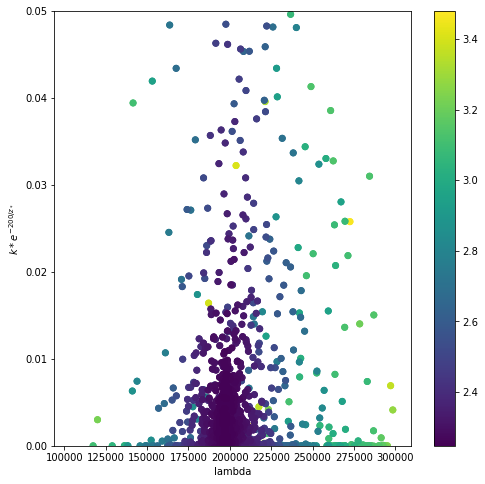

In [22]:
#examine history
plt.figure(figsize=(8,8))
return_df = history.get_population_extended(t = "all")
return_df.to_csv('step2_results_' + str(run_number).zfill(3) + '.csv')

sorted_by_fit = return_df.sort_values('distance')
sorted_by_fit = sorted_by_fit.iloc[::-1]
lambdas = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__travel_dist']['par_val']
ks = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__k_factor']['par_val']
z0s = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__k_depth_scale']['par_val']
misfits = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__travel_dist']['distance']
ts = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__travel_dist']['t']
plt.scatter(lambdas, np.array(ks) * np.exp(-200/np.array(z0s)), c = np.log(misfits))
#sorted_by_fit = return_df.sort_values('distance')
#plt.scatter(sorted_by_fit.iloc[3, 7], np.array(sorted_by_fit.iloc[2, 7]) * np.exp(-200/np.array(sorted_by_fit.iloc[1,7])), c = 'r')
plt.xlabel('lambda')
plt.ylabel(r'$k*e^{-200/z_*}$')
plt.colorbar()
plt.ylim(0, 0.05)
#for i in range(len(ts)):
#    plt.annotate(str(ts.iloc[i]), (lambdas.iloc[i], ks.iloc[i] * np.exp(-200/z0s.iloc[i])))

(0.0, 200.0)

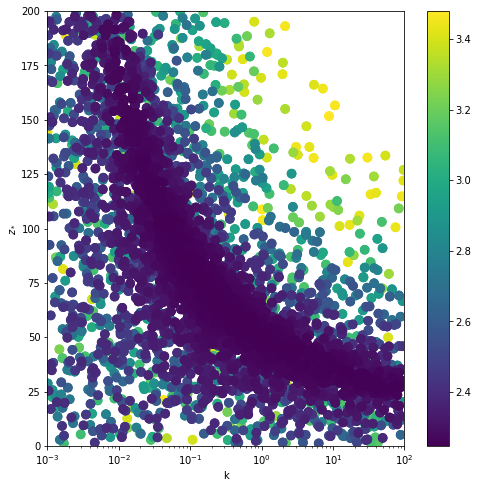

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(np.power(10, np.array(ks)), np.array(z0s), c = np.log(misfits), s=75)
#plt.scatter(np.float(sorted_by_fit.iloc[2, 7]), np.float(sorted_by_fit.iloc[1,7]), c = 'r')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel(r'$z_*$')
plt.colorbar()
plt.xlim(0.001, 100)
plt.ylim(0, 200)

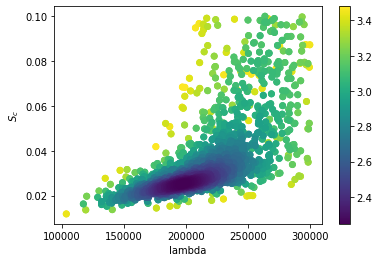

In [25]:
scs = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__s_crit']['par_val']
plt.scatter(lambdas, scs, c = np.log(misfits))
#sorted_by_fit = return_df.sort_values('distance')
#plt.scatter(sorted_by_fit.iloc[3, 7], np.array(sorted_by_fit.iloc[0, 7]), c = 'r')
plt.xlabel('lambda')
plt.ylabel(r'$S_c$')
plt.colorbar()

In [ ]:
sorted_by_fit = return_df.sort_values('distance')
print(sorted_by_fit.iloc[0:8, :])

In [26]:
#extract and save the best fit params int he following order:
#travel distance, k, z*, Sc
sorted_by_fit = return_df.sort_values('distance')

particle_id_of_best_fit = sorted_by_fit.iloc[0, 4]
best_fit_params = sorted_by_fit[sorted_by_fit['particle_id'] == particle_id_of_best_fit]

best_fit_travel_dist = best_fit_params['par_val'][best_fit_params['par_name'] == 'erode__travel_dist']
best_fit_k = best_fit_params['par_val'][best_fit_params['par_name'] == 'erode__k_factor']
best_fit_depth_scale = best_fit_params['par_val'][best_fit_params['par_name'] == 'erode__k_depth_scale']
best_fit_s_crit = best_fit_params['par_val'][best_fit_params['par_name'] == 'erode__s_crit']
print(np.float(best_fit_s_crit.iloc[0]))
best_fit_params = np.array([np.float(best_fit_travel_dist.iloc[0]), 
                           np.float(best_fit_k.iloc[0]), 
                           np.float(best_fit_depth_scale.iloc[0]), 
                           np.float(best_fit_s_crit.iloc[0])]
                          )

np.save('best_fit_params_run7.npy', best_fit_params)

0.025261055557777835


In [27]:
sorted_by_fit

,t,epsilon,samples,w,particle_id,distance,par_name,par_val,sumstat_name,sumstat_val
28967,12,9.670693,1021,0.002161,42177,9.459640,erode__travel_dist,197764.725405,params_for_record,"[197764.72540501028, -0.6245683832860013, 64.9..."
28960,12,9.670693,1021,0.002161,42177,9.459640,erode__k_depth_scale,64.961912,data,"[0.0, 212.07364609479654, 707.6006285681497, 1..."
28961,12,9.670693,1021,0.002161,42177,9.459640,erode__k_factor,-0.624568,data,"[0.0, 212.07364609479654, 707.6006285681497, 1..."
28962,12,9.670693,1021,0.002161,42177,9.459640,erode__s_crit,0.025261,data,"[0.0, 212.07364609479654, 707.6006285681497, 1..."
28963,12,9.670693,1021,0.002161,42177,9.459640,erode__travel_dist,197764.725405,data,"[0.0, 212.07364609479654, 707.6006285681497, 1..."
...,...,...,...,...,...,...,...,...,...,...
1196,0,32.493880,736,0.003333,38706,32.454273,erode__k_depth_scale,108.818027,params_for_record,"[199175.27334016163, 0.003327970907396338, 108..."
1197,0,32.493880,736,0.003333,38706,32.454273,erode__k_factor,0.003328,params_for_record,"[199175.27334016163, 0.003327970907396338, 108..."
1198,0,32.493880,736,0.003333,38706,32.454273,erode__s_crit,0.068196,params_for_record,"[199175.27334016163, 0.003327970907396338, 108..."
1199,0,32.493880,736,0.003333,38706,32.454273,erode__travel_dist,199175.273340,params_for_record,"[199175.27334016163, 0.003327970907396338, 108..."


In [ ]:
best_fit = np.where(return_df['distance'] == min(return_df['distance']))[0][0]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(return_df.sort_values('distance'))

Now we visualize the probability density functions.
The vertical line indicates the location of the observation.
Given our model, we expect the mean to be close to the observed data.

In [ ]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="mean", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

pyABC also offers various other visualization routines in order to analyze the parameter estimation run:

In [ ]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
pyabc.visualization.plot_credible_intervals(
    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
    show_mean=True, show_kde_max_1d=True,
    refval={'mean': 2.5}, arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

In [ ]:
history.all_runs()

In [ ]:
from numpy import genfromtxt
all_params = genfromtxt('all_params.csv', delimiter=',')
all_distances = genfromtxt('all_distances.csv', delimiter=',')
plt.scatter(all_params[:, 0], all_params[:, 3], c = np.log(all_distances), vmin=np.log(8.43), vmax=np.log(20))


In [ ]:
max(all_distances)

In [ ]:
all_params

In [ ]:
all_output = np.column_stack((all_params,all_distances))
all_output=all_output[all_output[:,-1].argsort()[::-1]] #sort by misfit
#len(all_output[:-1])
print(all_output[:,:])

In [ ]:
#plt.figure(figsize=(8,8))
plt.scatter(all_output[:, 1][::-1], all_output[:, 2][::-1], c = np.log(all_output[:,-1][::-1]), s=75)
#plt.scatter(np.float(sorted_by_fit.iloc[2, 7]), np.float(sorted_by_fit.iloc[1,7]), c = 'r')

plt.xlabel('k')
plt.ylabel(r'$z_*$')
plt.colorbar()
plt.xlim(0, 1)
plt.ylim(0, 150)

In [ ]:
#scs = sorted_by_fit[sorted_by_fit['par_name'] == 'erode__s_crit']['par_val']
plt.scatter(all_output[:, 0], all_output[:, 3], c = np.log(all_output[:, -1]), vmin=np.log(8.43), vmax=np.log(20))
#plt.scatter(all_output[-1, 0], all_output[-1, 3], c = 'r')
plt.scatter(1.76152018e+05, 2.95003540e-02, edgecolors = 'r', marker='o', facecolors='None', s = 100)

#sorted_by_fit = return_df.sort_values('distance')
#plt.scatter(sorted_by_fit.iloc[3, 7], np.array(sorted_by_fit.iloc[0, 7]), c = 'r')
plt.xlabel('lambda')
plt.ylabel(r'$S_c$')
plt.colorbar()

In [ ]:
all_output[-10000:, :][(all_output[-10000:, 3]>0.028) & (all_output[-10000:, 0]<200000)]

In [ ]:
min(all_output[:, -1])

In [ ]:
np.log(1.07360280e+01)

In [ ]:
np.log(8.74)

In [ ]:
np.log(12)